# Restauration d'image à l'aide de l'ADMM
*ZHAO Fubang*

In [198]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import inv
from scipy import sparse
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Load data

In [118]:
data = pickle.load(open('dataforpython2.pk', 'rb'))
original = data.get('original')
H = data.get('H')
y = data.get('observations')
T = data.get('T')
print original.shape, H.shape, y.shape, T.shape
P = T.shape[1]
Q = T.shape[0]
print P, Q

(64, 64) (4096, 4096) (64, 64) (8064, 4096)
4096 8064


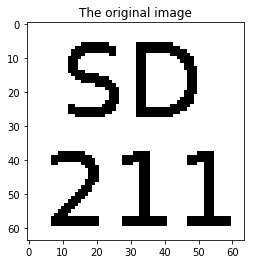

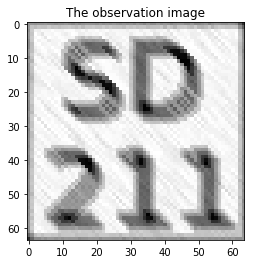

In [21]:
plt.imshow(original, cmap='gray')
plt.title('The original image')
plt.show()
plt.imshow(y, cmap='gray')
plt.title('The observation image')
plt.show()

## 2 Restauration d'image
### 2.2 Algorithme ADMM
#### Préparation 1
$f(x) = \frac{1}{2}\|y - Hx\|^2_2$<br><br>
$g(z) = \beta\|Tz_2\|_1 + \boldsymbol{\iota}_{[0,1]}p(z_1)$<br><br>
$A = 
\begin{pmatrix}
I_{P}\\ 
T
\end{pmatrix}$
<br>

#### Préparation 2
$\mathcal{L}_\rho(x, z^k, \gamma^k) = f(x) + g(z) + \gamma^T(Ax-z) + \frac{\rho}{2}\|Ax - z\|^2_2$<br><br>
$\mathcal{L}_\rho(x, z^k, \gamma^k) = \frac{1}{2}\|y - Hx\|^2_2 + \beta\|z_2\|_1 + \boldsymbol{\iota}_{[0,1]}p(z_1) + \gamma_1^T(x-z_1) + \gamma_2^T(Tx-z_2) + \frac{\rho}{2}\|x - z_1\|^2_2 + \frac{\rho}{2}\|Tx - z_2\|^2_2$
<br>

#### Préparation 3
$\frac{\partial \mathcal{L}_\rho(x, z^k, \gamma^k)}{\partial x} = 0$<br><br>
$x = (H^TH + \rho I + \rho T^TT)^{-1}(H^Ty - \gamma_1 - \gamma_2T + \rho z_1 + \rho T^Tz_2)$
<br>

#### Préparation 4
$\frac{\partial \mathcal{L}_\rho(x, z^k, \gamma^k)}{\partial z_1} = 0$<br><br>
$\frac{\partial \mathcal{L}_\rho(x, z^k, \gamma^k)}{\partial z_2} = 0$<br><br>
$z_1 =
\begin{cases}
\frac{\gamma_1}{\rho} + x & \text{ if } 0 \leq z_1 \leq 1\\ 
0 & \text{ if } z_1<0 \\ 
1 & \text{ if } z_1>1
\end{cases}
$

$z_2 =
\begin{cases}
\frac{-\beta + \gamma_2}{\rho} + Tx & \text{ if } z \geq 0\\ 
\frac{\beta + \gamma_2}{\rho} + Tx  & \text{ if } z<0 \\
0 & \text{ if } otherwise
\end{cases}
$
<br>
#### Préparation 5
$\gamma_1^{k+1} = \gamma_1^k + \rho(x^{k+1} - z_1^{k+1})$<br><br>
$\gamma_2^{k+1} = \gamma_2^k + \rho(Tx^{k+1} - z_2^{k+1})$

In [147]:
def z1_trans(gamma1, x, rho):
    res = gamma1 / rho + x
    res[res < 0] = 0
    res[res > 1] = 1
    return res

def z2_trans(gamma2, rho, beta, T, x):
    if beta < 0:
        print("beta needs to be positive!")
    tmp = gamma2 + rho * T.dot(x)
    res = np.zeros(tmp.shape[0])
    res[tmp >= beta] = ((tmp - beta) / rho)[tmp >= beta]
    res[tmp <= -beta] = ((tmp + beta) / rho)[tmp <= -beta]
    return res

## 3 Implémentation de l'ADMM pour résoudre le problème de res- tauration d'image
### Manipulation 2

In [172]:
rho = 0.05
beta = 0.01
k_max = 100
y = y.ravel()
original = original.ravel()
gamma1_0 = np.zeros(P)
gamma2_0 = np.zeros(Q)
z1_0 = np.ones(P)
z2_0 = T.dot(z1_0)
print y.shape, original.shape, gamma1_0.shape, gamma2_0.shape, z1_0.shape, z2_0.shape

(4096,) (4096,) (4096,) (8064,) (4096,) (8064,)


In [189]:
def admm(z1_0, z2_0, gamma1_0, gamma2_0, H, T, rho, beta, k_max, y, original, pic_flag):
    res = []
    eqm = []
    z1, z2, gamma1, gamma2 = z1_0, z2_0, gamma1_0, gamma2_0
    tmp = inv(H.T.dot(H) + rho * sparse.identity(P) + rho * T.T.dot(T))
    for i in xrange(k_max):
        x = tmp.dot(H.T.dot(y) - gamma1 - T.T.dot(gamma2) + rho * z1 + rho * T.T.dot(z2))
        z1 = z1_trans(gamma1, x, rho)
        z2 = z2_trans(gamma2, rho, beta, T, x)
        gamma1 = gamma1 + rho * (x - z1)
        gamma2 = gamma2 + rho * (T.dot(x) - z2)
        res_tmp_first = np.sum((y - H.dot(x)) ** 2) / 2.
        res_tmp = res_tmp_first + beta * np.sum(np.abs(T.dot(x)))
        res.append(res_tmp)
        eqm_tmp = np.sum((x - original) ** 2) / P
        eqm.append(eqm_tmp)
    if pic_flag:
        plt.plot(res)
        plt.title('The curve of the value of function')
        plt.show()
        plt.plot(eqm)
        plt.title('The curve of the EQM')
        plt.show()
        print "The minimal value is: %r" %res_tmp
        print 'The final result of EQM is: %r' %eqm_tmp
    return x, res_tmp, res_tmp_first, eqm_tmp

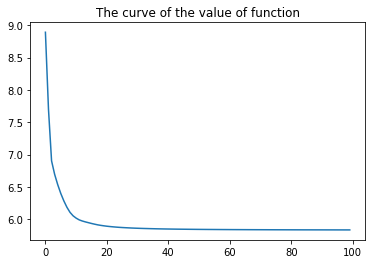

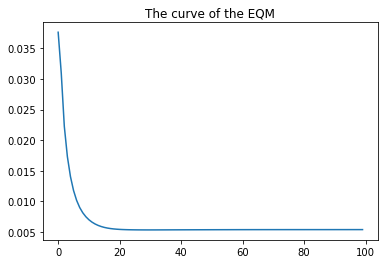

The minimal value is: 5.8355575249207225
The final result of EQM is: 0.0053874598192400446
The final bias is: array([-0.03650837, -0.03644563, -0.03636398, ..., -0.04494459,
       -0.04492612, -0.04491112])


In [233]:
res_x = admm(z1_0, z2_0, gamma1_0, gamma2_0, H, T, rho, beta, 100, y, original, True)[0]
print 'The final bias is: %r' %(res_x-original)

### Manipulation 3
As shown in the figure above, obviously, the curve converges very fast, and the result is almost equal to zero.

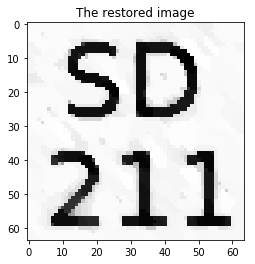

In [157]:
plt.imshow(np.reshape(res_x, (64,64)), cmap='gray')
plt.title('The restored image')
plt.show()

### Manipulation 4

In [234]:
rho_range = np.arange(0.0001, 0.1, 0.01)
beta_range = np.arange(0.0001, 0.02, 0.002)

In [235]:
res_tune = np.zeros((len(rho_range), len(beta_range)))
res_eqm = np.zeros((len(rho_range), len(beta_range)))
for i in xrange(len(rho_range)):
    for j in xrange(len(beta_range)):
        res_tune[i][j], res_eqm[i][j] = admm(z1_0, z2_0, gamma1_0, gamma2_0,
                                             H, T, rho_range[i], beta_range[j], 20, y, original, False)[2:4]

In [264]:
def show_3d(res, title, z_lim):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca(projection='3d')
    # Make data.
    X_3d, Y_3d = np.meshgrid(rho_range, beta_range)

    # Plot the surface.
    surf = ax.plot_surface(X_3d, Y_3d, res, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.set_zlim(0, z_lim)
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel('rho')
    ax.set_ylabel('beta')
    ax.set_zlabel('result')
    plt.title(title)
    plt.show()

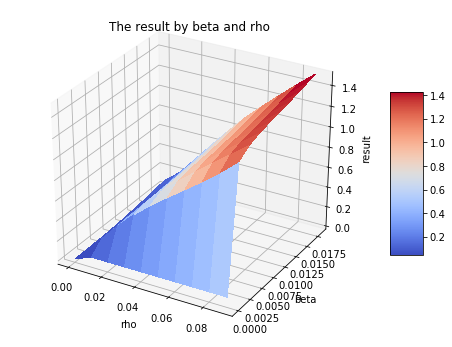

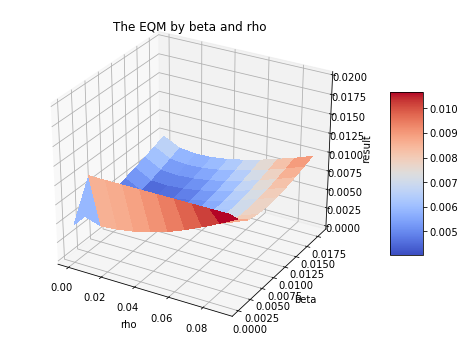

In [265]:
show_3d(res_tune, 'The result by beta and rho', 1.5)
show_3d(res_eqm, 'The EQM by beta and rho', 0.02)

In this question, I took the first part of the original question to avoid the effects of $\beta$. I used 3D plot to show the changes of result of function and EQM with the changes of beta and rho.
From the figures above, we can still see that:
1. For the result of function:<br>
    The result of function increases with the increase of $\beta$ and $\rho$
2. For the EQM:<br>
    When the $\beta$ increases, normally, the EQM decreases firstly and then increases, but the changes of EQM with $\rho$ was not that clear.